In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import gensim
import html
import re
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

In [6]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [16]:
#DATA

df_train = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/train.csv")
df_test = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/test.csv")
df_labels = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

df.drop(df[(df['label'] == 1) & (df['id'] < 1080)].index, inplace = True)
df = df.sample(frac=1)

In [21]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
#removes HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
#removes all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
#removes URLs
    clean = re.sub('\W+',' ', clean)                   
#replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

In [22]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [23]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

9975     economic nationalism alternative globalism cor...
19942    ashton kutcher blow kiss john mccain senate he...
8904     brexit divorce trade talk late tell york time ...
21588    driver pull stop suicidal woman jump bridge br...
2885     merkel vow stay course despite party setback y...
                               ...                        
4504     priority immigrant sweep deportation york time...
5794     dennis kucinich extraordinary warn think tank ...
14658    breitbart news daily trump bureaucrat breitbar...
12613    graft allegation grow françois fillon french p...
23334    gary miliefsky ransomware attack cybercrime tr...
Name: clean_joined, Length: 25456, dtype: object


In [24]:
#WORD2VEC

# Target class is 'label'
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.label, test_size=0.2)

# Creating list of lists of unigrams - training corpus
corpus_train = x_train
lst_coprus_train = []
for string in corpus_train:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_coprus_train.append(lst_grams)

# Fitting Word2Vec
nlp = word2vec.Word2Vec(lst_coprus_train, vector_size=300, window=8, min_count=1, sg=1)

# Listing similar words to 'trump'
print(nlp.wv.most_similar('trump'))

# Creating list of lists of unigrams - testing corpus
corpus_test = x_test
lst_coprus_test = []
for string in corpus_test:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_coprus_test.append(lst_grams)


[('donald', 0.7843979001045227), ('cahaly', 0.7375540733337402), ('hrafnkell', 0.7262442708015442), ('haraldsson', 0.720437228679657), ('tepidly', 0.7173629999160767), ('sopan', 0.7155713438987732), ('castellanos', 0.7147946357727051), ('gopers', 0.7138097882270813), ('pushover', 0.7132366299629211), ('byars', 0.7130036950111389)]


In [25]:
print(nlp.wv.most_similar('president'))

[('bandow', 0.6985756158828735), ('illegitimately', 0.6968811750411987), ('presidency', 0.6962102651596069), ('carafano', 0.6954377889633179), ('valedictory', 0.6952990293502808), ('interregnum', 0.687689483165741), ('aissami', 0.6844502091407776), ('hormats', 0.6796375513076782), ('grenell', 0.6792427897453308), ('shamefully', 0.6773372292518616)]


In [27]:
print(df.clean_joined[4504])

priority immigrant sweep deportation york time washington agent knock door modest duplex wisconsin town dawn mexican immigrant live grind floor stick head ask give minute josé cervantes amaral handcuff wife mexico silently watch year work live quietly unite state cervantes legal paper ride away seat head deportation routine continue daily supreme court thursday effectively end initiative president obama give protection deportation million immigrant country illegally parent american citizen obama show frustration decision say goal help immigrant raise family help country work president say immigrant qualify program safe deportation deportation continue thousand week november obama announce protection program priority enforcement immigration authority focus remove convict criminal foreigner pose national security threat administration priority include deport migrant central america include child come influx immigrant commit minor offense sweep operation thursday supreme court decision pr

In [28]:
#TOKENIZATION AND PADDING

# Tokenizing words and creating sequneces of tokenized words
tokenizer = Tokenizer(lower=True, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_coprus_train)
dic_vocabulary = tokenizer.word_index

lst_text2seq_train = tokenizer.texts_to_sequences(lst_coprus_train)
lst_text2seq_test = tokenizer.texts_to_sequences(lst_coprus_test)


# Adding padding
padded_train = pad_sequences(lst_text2seq_train, maxlen=40, padding='post', truncating='post')
padded_test = pad_sequences(lst_text2seq_test, maxlen=40, truncating='post')


# Starting the embedding matrix
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

for word, idx in dic_vocabulary.items():
    # Update the row with vector
    try:
        embeddings[idx] = nlp.wv[word]
    # If word not in model skip and row stays all 0s
    except:
        pass

In [29]:
#SHOWING HOW A TEXT FROM DF IS TRANSFORMED INTO A SEQ WITH PADDING

i = 0

## list of text
len_txt = len(df["clean_joined"].iloc[i].split())
print("from: ", df["clean_joined"].iloc[i], "| len:", len_txt)

## sequence of token ids
len_tokens = len(padded_train[i])
print("to: ", padded_train[i], "| len:", len(padded_train[i]))

## vocabulary
print("check: ", df["clean_joined"].iloc[i].split()[0], " -- idx in vocabulary -->", dic_vocabulary[df["clean_joined"].iloc[i].split()[0]])
print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  economic nationalism alternative globalism corporate takeover economy business globalism ivory tower economist corporate business analyst financial expert routinely trash discussion america need institute national economic policy actually benefit country mantra unchallenged doctrine globalism path world commerce intensively push half century unite state fare honest evaluation acknowledge diminish middle class pay great penalty corporatist sedition destroy internal independence productive prosperity build viable enterprise conduct useful economic activity produce need desirable good service good pay job grow velocity money flow real domestic economy international trade advantageous benefit party involve prosperity transaction free framework maximize corporatism structure particular country jurisdiction trade policy globalists exact opposite laud free trade conduit argument point inconsistency economic nationalism globalism ask economic nationalism reaction global integration esse

In [30]:
#BUILDING AND TRAINING MODEL

model = Sequential()
# takes the sequences as input and the word vectors as weightstakes the sequences as input and the word vectors as weights
model.add(Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings]))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100))) # 100 memory units (smart neurons)
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

y_train = np.asarray(y_train)

#Training the mode
training = model.fit(padded_train, y_train, batch_size=64, validation_split=0.3, epochs=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         42917100  
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 43,238,101
Trainable params: 43,238,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
223/223 [==============================] - 230s 984ms/step - loss: 0.3657 - accuracy: 0.8546 - val_l

Model accuracy is :  0.884917517674784
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2582
           1       0.86      0.91      0.89      2510

    accuracy                           0.88      5092
   macro avg       0.89      0.89      0.88      5092
weighted avg       0.89      0.88      0.88      5092



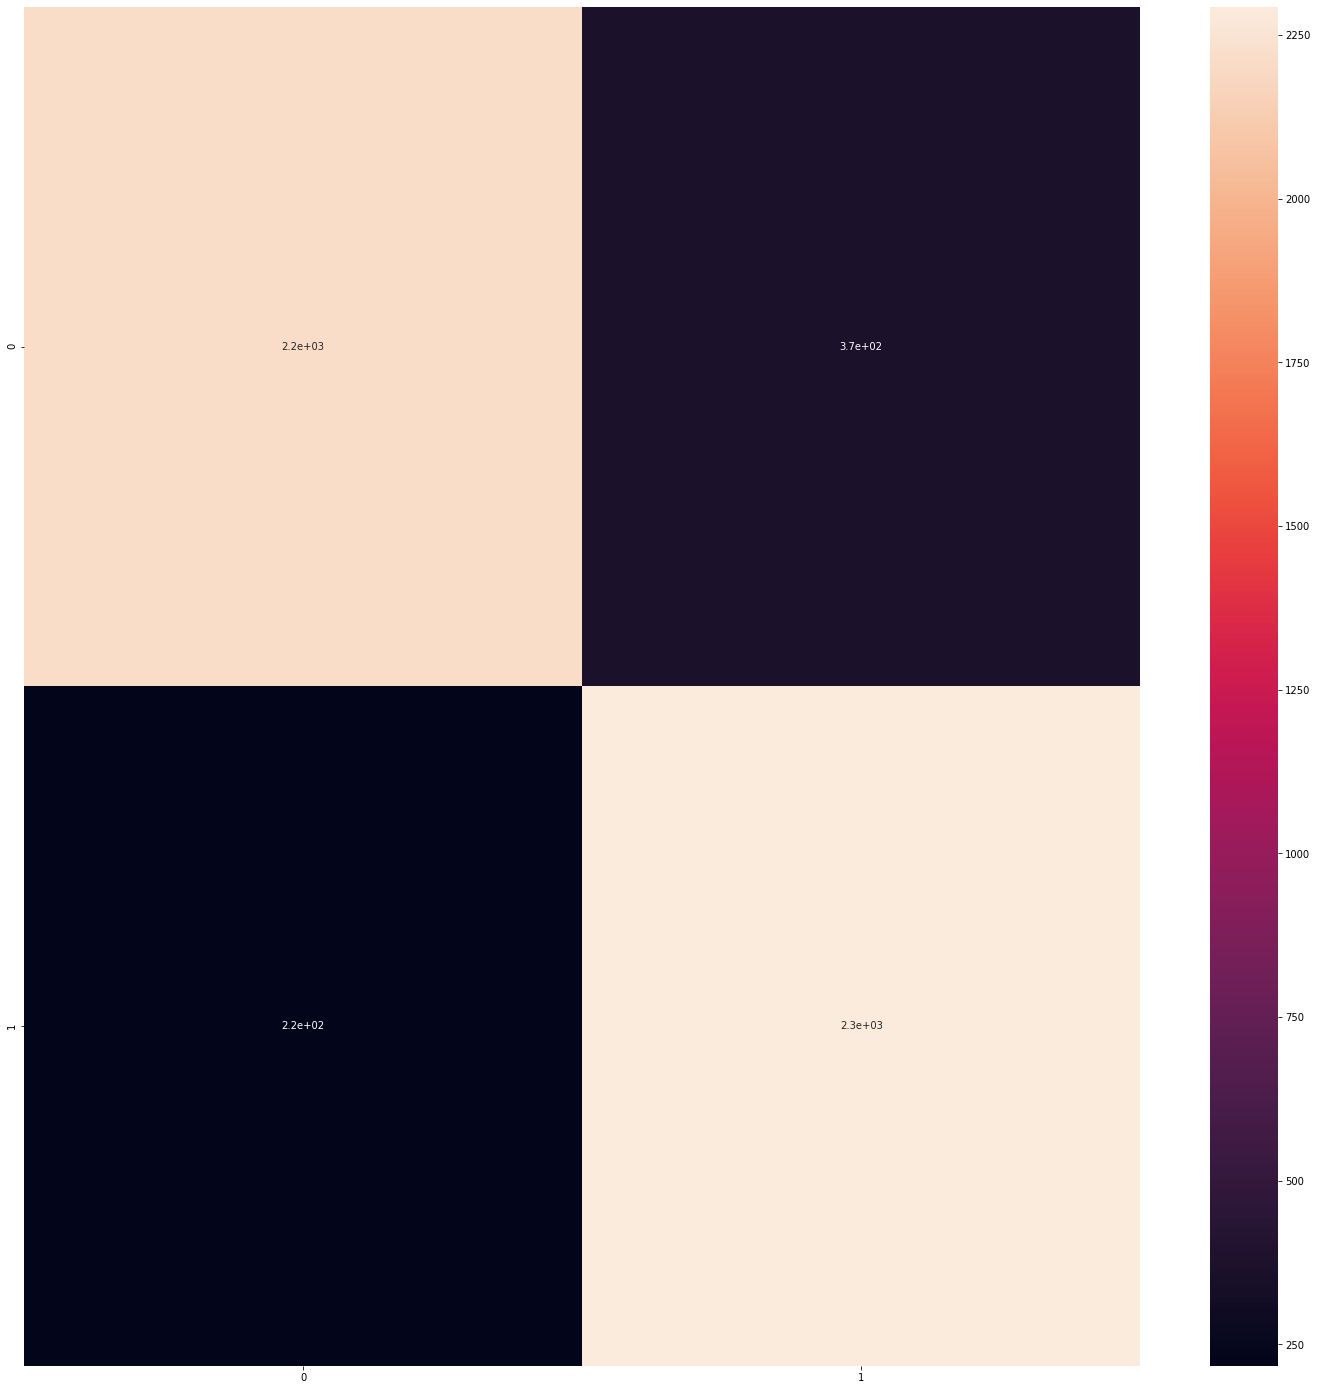

In [34]:
#ASSESING TRAINED MODEL PERFORMANCE

## Plot confusion matrix

pred = model.predict(padded_test)

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

In [ ]:
df_pred = pd.DataFrame(pred, columns = ['output'])

In [32]:
for X,Y,Z in zip(pred,y_test, x_test):
    print("Model Score:", X, "\nactual score:", Y, "\ntext:", Z, "\n-----------------------") 

Model Score: [0.04825115] 
actual score: 0 
text: donald trump blow gaffe york time politician say stupid reporter traditionally expect mask glee veneer shock disappointment mode news political director chuck todd colleague carrie dann begin edition read network daily political sheet warn donald trump campaign go unravel break glass mode begin heroic attempt catalog previously thing trump say precede hour long list include candidate display rally audience purple heart medal give retire army lieutenant colonel wound iraq want purple heart say trump receive draft deferment vietnam thing bone spur miraculously little impact youthful athletic career easy word mouth past presidential candidate republican democrat comment certainly label near gaffe todd dann write blockbuster trump news afternoon prompt consider come pair political journalist border heresy maybe muse look gaffe gaffe prepolitical usage essentially faux breach etiquette diplomatic context appear local custom anonymous british

actual score: 0 
text: taliban chief target drone strike pakistan signal shift york time kabul afghanistan month fail pakistani effort broke peace talk taliban american drone strike leader afghan militant signal major break precedent unite state circumvent pakistan effort disrupt strengthen insurgency official say sunday afghan intelligence agency say sunday taliban leader mullah akhtar muhammad mansour kill strike restive pakistani province baluchistan unite state announce strike saturday confirm mullah mansour kill official reaction main taliban spokesman taliban commander sunday deny report say leader area strike mullah mansour kill attack significant believe american drone strike baluchistan facto headquarter afghan taliban year attack pakistani afghan area death mullah mansour consolidate authority fracture taliban militant major gain battlefield throw insurgency second leadership crisis year unclear create significant breathe space afghan government president ashraf ghani struggl

Model Score: [0.860854] 
actual score: 1 
text: genius schizophrenic pas question quiz david avocado wolfe davidwolfe item genius schizophrenic pas question quiz neuroscientist estimate brain activity unconscious think second unconscious activity influence heavily world subconscious cue demonstrate go super cool quiz premise simple genius schizophrenic answer follow question continue hint know test rely researcher contraposition method method test extent person awareness brain process power super complicate method ton move part speak need know purpose article object reasonably unrelated people assume example race hurricane little connection genius think outside deduce sort connection schizophrenic patient deduce connection illness make people existent connection word quiz article leave scratch head normal thing true brilliant schizophrenia worry leave guess fact help figure genius take time think blurt response answer right think schizophrenic genius schizophrenia angle go post diagnos

Model Score: [0.9412476] 
actual score: 1 
text: hillary bad judgment wikileaks release podesta file email total usual parse disclosure bring notable one february email chelsea clinton alias podesta mill hillary frustrate daughter point frustration confusion clinton foundation client aftermath previously note scandal plague clinton consultancy teneo past day people foundation reach frustrate upset blank largely derive meet friday monday respond essentially follow emphatically call night tell explicit involvement push think right answer thank sample share concern example pull punch john cheryl appropriate feel strongly directly transition challenge right answer critical voice hear understand direct intermediation particularly effort professionalism efficiency foundation father decision maker february email neera tanden lash david brock bonner group profile post money launder scheme expose clinton super pac profit implicate reminder bonner group show month money launder involve superpacs

Model Score: [0.23801601] 
actual score: 1 
text: border patrol find pound meth border patrol agent southwestern arizona discover pound methamphetamine drug inland border checkpoint agent assign yuma sector observe dodge pickup truck approach interstate inland border checkpoint locate east yuma arizona cursory check truck agent alert possible presence drug accord information provide breitbart texas custom border protection spokesman justin kallinger agent conduct secondary inspection truck inspection discovery drug hide inside spare tire official state agent drug hide truck seat agent pound heroin pound pound methamphetamine agent arrest driver dodge pickup truck identify citizen disclose driver identity official statement official seize truck drug estimate worth street value suspect turn federal enforcement agency possible prosecution drug traffic law area know drug traffic human smuggle march breitbart texas report crash occur human smuggler attempt flee border patrol agent border pa

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




-----------------------
Model Score: [0.0517112] 
actual score: 0 
text: miranda suspect kayak kill understand right lawyer say york time goshen angelika graswald woman accuse kill fiancé kayak out year ask investigator miranda hour read miranda right accord testimony pretrial hear tuesday investigator graswald lawyer richard portale seek client native latvia grasp implication police interrogation precede arrest charge client portale say court ask miranda miranda investigator donald dequarto respond felt confident early police interrogation graswald comprehend right ask understand state dequarto say remember read piece paper write piece paper miranda warn interrogation graswald admit remove drain plug kayak belong fiancé vincent viafore tamper paddle viafore drown april kayak capsize rough water hudson river miranda warn usually read suspect start police interrogation alert right remain silent obtain lawyer intend preserve admissibility evidence trial miranda right case involve ernest

Model Score: [0.9557245] 
actual score: 1 
text: finally know hillary disappear election night cry inconsolably hard understand say cry hard donald trump election high office land inevitable tuesday night daily sheeple report clinton campaign mysteriously go dark know report clinton campaign go completely dark long talk medium trump hillary itsover election daily sheeple thedailysheeple november hillary know publish victorious tweet supporter hour official count start confirm team proud happen tonight thank twitter iwozill hillary clinton hillaryclinton november confirmation trump victory sweep world undoubtedly wonder go hillary mind report clinton concession come forefront turn hillary unprecedented lose presidential candidate refuse stage thousand distraught party goer expect coronation firework instead hillary controversial campaign manager john podesta take stage announce election vote count imply hillary concede moment know wrong wrong hillary health episode trump hillary vote hi

-----------------------
Model Score: [0.03011447] 
actual score: 0 
text: platinum hedge fund executive charge billion fraud york time year york hedge fund platinum partner stand investment return rival big name industry turn return good true accord federal prosecutor federal agent monday arrest mark nordlicht founder chief investment officer platinum charge relate billion fraud firm operate like ponzi scheme prosecutor say large fraud case bernard madoff investment firm unravel david levy firm investment officer arrest morning agent texas manhattan rochelle suburb york city charge security fraud investment adviser fraud accord unseal indictment file federal district court brooklyn security exchange commission file parallel civil case platinum tap prominent family foundation orthodox jewish community york fuel bet payday lender company terminally prosecutor say investment firm performance misrepresent executive ultimately platinum take money order longtime investor want money firm exec

text: skype scam fortune build shame skype scam fortune build shame moroccan boomtown get rich trick internet publish min news night young palestinian live abroad fell victim online scam involve camera beautiful woman samir real tell story trap reda mawy visit moroccan boomtown scammer base warn story contain description sexual act happen home girl add facebook think strange friend request school friend know send message profile like look profile mean 
-----------------------
Model Score: [0.93699706] 
actual score: 1 
text: speak abortion see miscarry baby alert angry local drive past refugee center unthinkable go chatter litter news fee presidential election wednesday night debate move day desperately miss baby lose miscarriage stillbirth choose help word andrew write time year watch hear donald trump sympathetic dare convict say say concern abortion acceptable appoint life supreme court justice christian choice clear continue refer nominee stance abortion assert presidential debate 

Model Score: [0.03164423] 
actual score: 0 
text: bannon give security role usually hold general york time washington whirlwind week donald trump presidency bravura hallmark stephen bannon production start inauguration homily american carnage unite state city bannon follow day late shut message news medium week culminate blizzard executive order hatch bannon team white house policy adviser stephen miller aim disorient enemy fulfil campaign promise distract attention trump flawless debut define moment bannon come saturday night form executive order give rumple agitator seat principal committee national security council downgrade role chairman joint chief staff director national intelligence attend council consider issue direct area startle elevation political adviser status alongside secretary state defense president military intelligence adviser theory bannon navy surface warfare officer admiral aide investment banker hollywood producer breitbart news firebrand level friend michael fly

Model Score: [0.03209648] 
actual score: 0 
text: code rewrite lobbyist scramble york time washington homebuilder lobby fear ambitious rewrite entire code stifle house market retailer fret cost import soar charity representative worry donation stunt plague nonprofit group serve needy american president trump treasury secretary steven mnuchin casually predict week true overhaul federal code decade happen lawmaker head home august recess problem swamp trump like talk campaign trail undrained dweller swamp mobilize protect patch army corporate lobbyist scramble protect favorite provision exception deduction late trench talk enact sweep legislation span month sound like bravado naïveté delusion definition overhaul create winner loser billion dollar stake prospect revamp create fierce infighting republican mass lobbyist force underwrite divide business community reform series battle say sage eastman work vain overhaul plan longtime senior aide house way mean committee lobby mehlman castagne

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

